#### STEP 1 : 시계열 데이터 준비

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import warnings
warnings.filterwarnings('ignore')

# dataset_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/data/daily-min-temperatures.csv' 
from pathlib import Path
directory = Path.joinpath(Path.cwd(),'data')


# Nvidia 주가예측

In [2]:
dataset_filepath = Path.joinpath(directory, 'NVDA.csv')
dataset_filepath = str(dataset_filepath)
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']
ts.head()

Date
2017-02-21    27.767500
2017-02-22    27.690001
2017-02-23    25.122499
2017-02-24    25.365000
2017-02-27    26.102501
Name: Close, dtype: float64

#### STEP 2 : 각종 전처리 수행  
결측치 처리  
로그 변환

In [3]:
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

In [4]:
ts=ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)

In [5]:
# 로그 변환
ts_log = np.log(ts)
# ts_log = ts

#### STEP 3 : 시계열 안정성 분석  
정성적 그래프 분석  
정량적 Augmented Dicky-Fuller Test  
시계열 분해(Time Series Decomposition)  
Residual 안정성 확인

In [6]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [7]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd  = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',  label='Original')    
    mean = plt.plot(rolmean,    color='red',   label='Rolling Mean')
    std  = plt.plot(rolstd,     color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

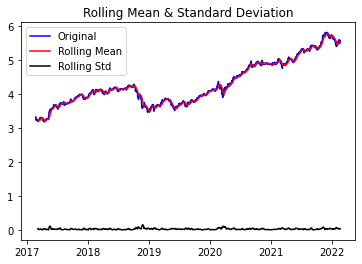

In [8]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=10)

In [9]:
rolmean = ts_log.rolling(window=10).mean() ##### rolmean을 사용해서 계산해 본다.
rolmean[rolmean.isna()] 

Date
2017-02-21   NaN
2017-02-22   NaN
2017-02-23   NaN
2017-02-24   NaN
2017-02-27   NaN
2017-02-28   NaN
2017-03-01   NaN
2017-03-02   NaN
2017-03-03   NaN
Name: Close, dtype: float64

In [10]:
rolmean_clean = rolmean.dropna()

In [11]:
rolmean_clean[rolmean_clean.isna()] 

Series([], Name: Close, dtype: float64)

Results of Dickey-Fuller Test:
Test Statistic                   -0.763237
p-value                           0.829683
#Lags Used                       21.000000
Number of Observations Used    1228.000000
Critical Value (1%)              -3.435686
Critical Value (5%)              -2.863896
Critical Value (10%)             -2.568025
dtype: float64


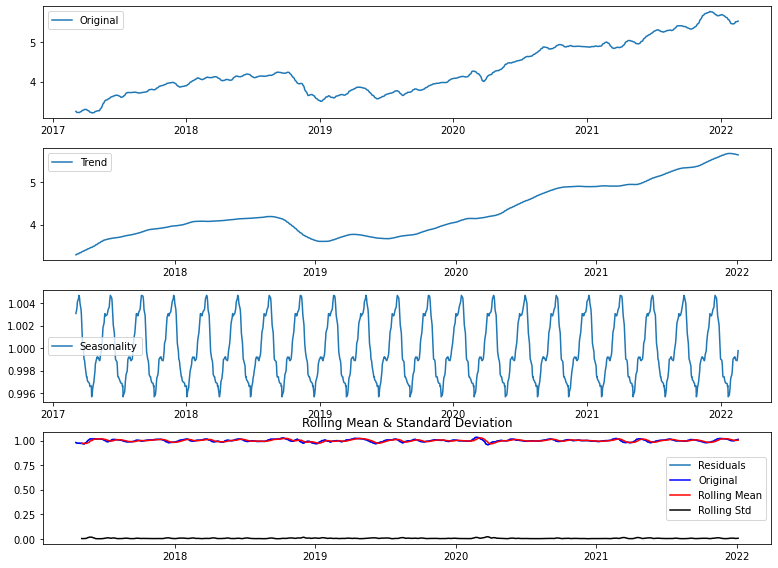

In [12]:
ts_log = rolmean_clean

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)
#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 60) 
trend         = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
seasonal      = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
residual      = decomposition.resid # 원본(로그변환한) - 추세 - 계절성
plt.rcParams["figure.figsize"] = (11,8)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

plt.rcParams["figure.figsize"] = (13,6)
plot_rolling_statistics(residual)

### 주식차트에서 흔히 사용되는 10일 평균선을 사용해서 나타내 보았지만 별다른 규칙성이라곤 찾아볼 수가 없다. p-value 또한 0.829683로 주기성이나 방향성이 가지고 있다고 보기는 어렵다.

#### STEP 4 : 학습, 테스트 데이터셋 생성

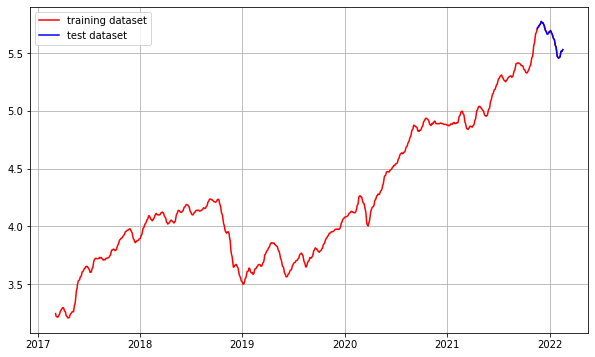

In [13]:
train_data, test_data = ts_log[:int(len(ts_log)*0.95)], ts_log[int(len(ts_log)*0.95):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

#### STEP 5 : 적정 ARIMA 모수 찾기

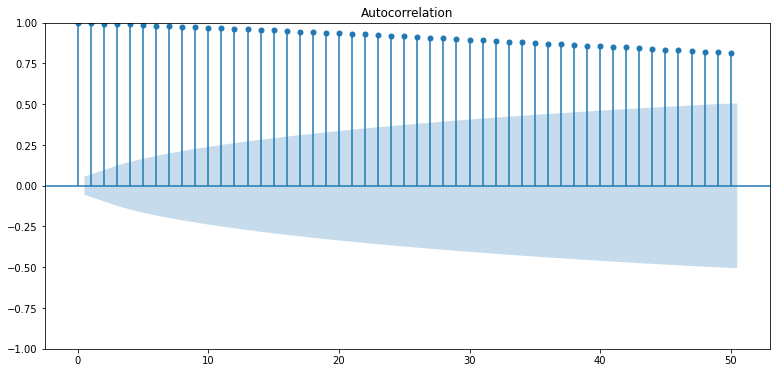

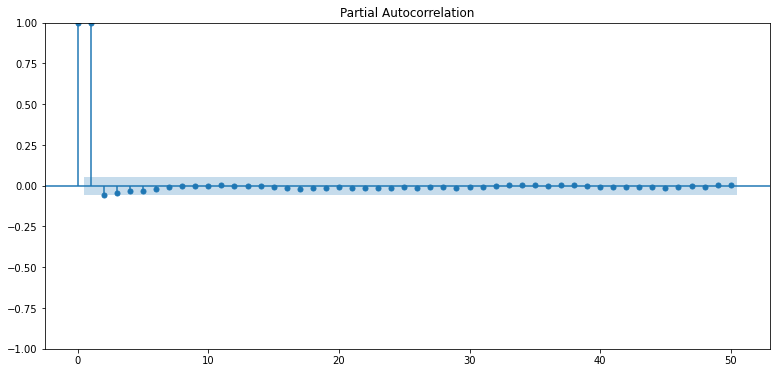

In [14]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(ts_log, lags=50)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log, lags=50)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

## pacf그래프로 p값을 찾아보면 4 정도로 보인다. acf 그래프로 q값을 찾아보면 0정도로 보인다.

Results of Dickey-Fuller Test:
Test Statistic                   -5.535038
p-value                           0.000002
#Lags Used                       20.000000
Number of Observations Used    1228.000000
Critical Value (1%)              -3.435686
Critical Value (5%)              -2.863896
Critical Value (10%)             -2.568025
dtype: float64


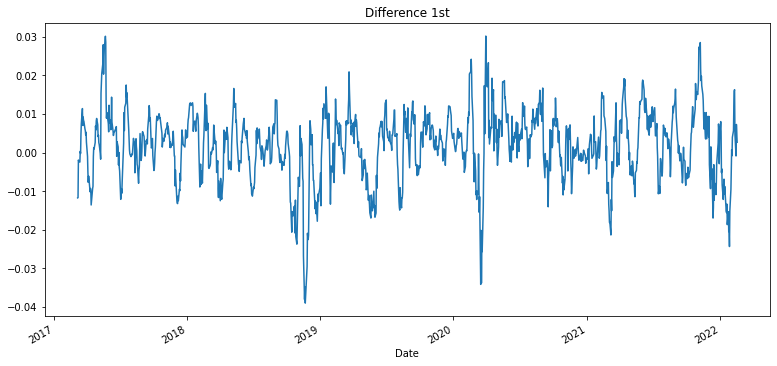

In [15]:
# 차분 안정성 확인 -> d 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

### 1차미분에 대한 p-value 0.000002로 작은 값이며 d = 1값을 사용하였다.

#### STEP 6 : ARIMA 모델 훈련과 테스트  
ARIMA 모델 빌드와 훈련  
모델 테스트 및 플로팅  
최종 예측 모델 정확도 측정(MAPE)

In [16]:
from statsmodels.tsa.arima.model import ARIMA
# Build and Train  Model
model = ARIMA(train_data, order=(4, 1, 0)) # 모수는 이전 그래프를 참고 
fitted_m = model.fit() 

print(fitted_m.summary())


C:\Users\ami\anaconda3\envs\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ami\anaconda3\envs\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ami\anaconda3\envs\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1187
Model:                 ARIMA(4, 1, 0)   Log Likelihood                4861.948
Date:                Fri, 18 Feb 2022   AIC                          -9713.897
Time:                        01:27:11   BIC                          -9688.505
Sample:                             0   HQIC                         -9704.326
                               - 1187                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8359      0.022     38.691      0.000       0.794       0.878
ar.L2          0.1882      0.025      7.381      0.000       0.138       0.238
ar.L3         -0.0884      0.035     -2.519      0.0

C:\Users\ami\anaconda3\envs\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


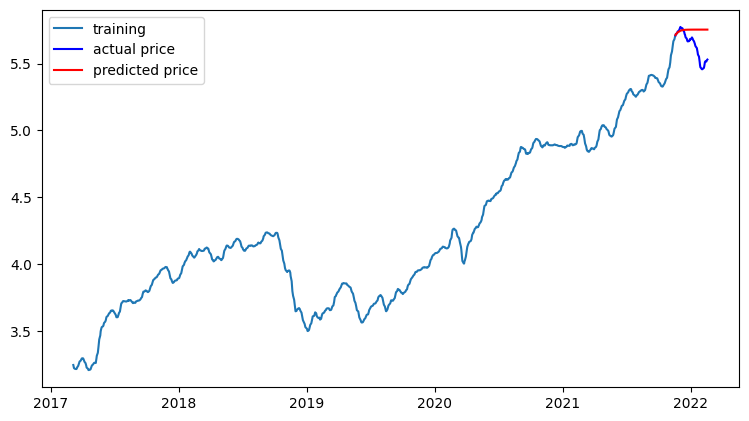

In [17]:

fc= fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r', label='predicted price')
plt.legend()
plt.show()

In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  1922.481668299227
MAE:  33.871919421938564
RMSE:  43.84611349138287
MAPE: 13.17%


# Apple 주가 예측

In [19]:
dataset_filepath = Path.joinpath(directory, 'AAPL.csv')
dataset_filepath = str(dataset_filepath)
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']
ts.head()


Date
2017-02-21    34.174999
2017-02-22    34.277500
2017-02-23    34.132500
2017-02-24    34.165001
2017-02-27    34.232498
Name: Close, dtype: float64

#### STEP 2 : 각종 전처리 수행  
결측치 처리  
로그 변환

In [20]:
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

In [21]:
ts=ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)

In [22]:
# 로그 변환
ts_log = np.log(ts)
# ts_log = ts

#### STEP 3 : 시계열 안정성 분석  
정성적 그래프 분석  
정량적 Augmented Dicky-Fuller Test  
시계열 분해(Time Series Decomposition)  
Residual 안정성 확인

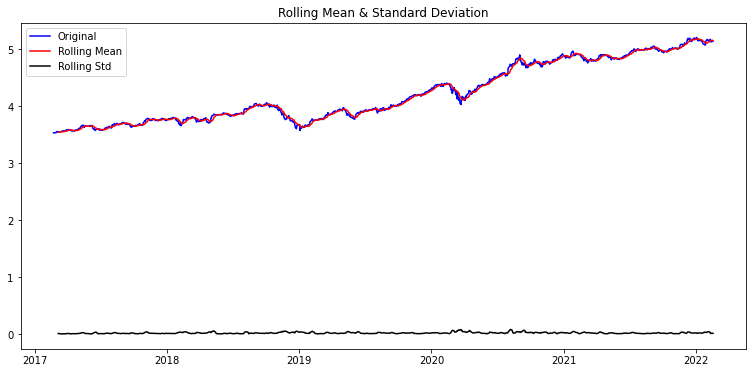

In [23]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=10)

In [24]:
rolmean = ts_log.rolling(window=10).mean() ##### rolmean을 사용해서 계산해 본다.
rolmean[rolmean.isna()] 

Date
2017-02-21   NaN
2017-02-22   NaN
2017-02-23   NaN
2017-02-24   NaN
2017-02-27   NaN
2017-02-28   NaN
2017-03-01   NaN
2017-03-02   NaN
2017-03-03   NaN
Name: Close, dtype: float64

In [25]:
rolmean_clean = rolmean.dropna()

In [26]:
ts_log = rolmean_clean

Results of Dickey-Fuller Test:
Test Statistic                   -0.116443
p-value                           0.947776
#Lags Used                       21.000000
Number of Observations Used    1228.000000
Critical Value (1%)              -3.435686
Critical Value (5%)              -2.863896
Critical Value (10%)             -2.568025
dtype: float64


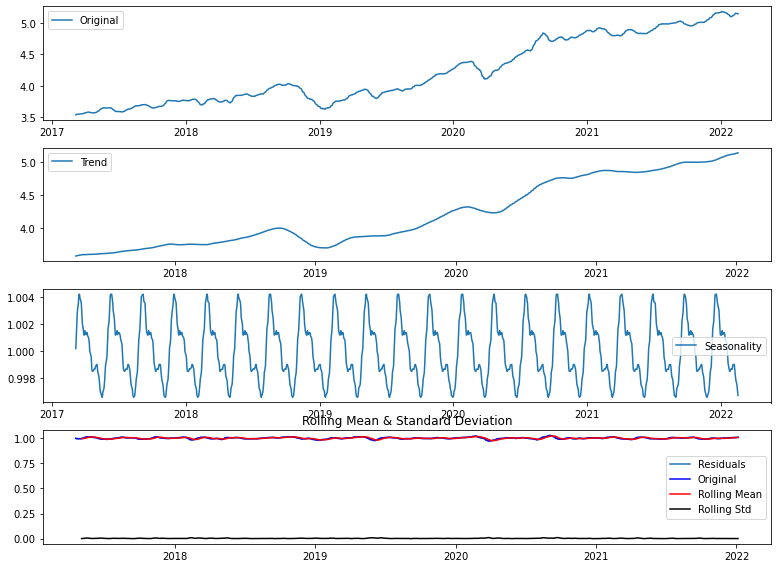

In [27]:

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 60) 
trend         = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
seasonal      = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
residual      = decomposition.resid # 원본(로그변환한) - 추세 - 계절성

plt.rcParams["figure.figsize"] = (11,8)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

plt.rcParams["figure.figsize"] = (13,6)
plot_rolling_statistics(residual)

### 주식차트에서 흔히 사용되는 10일 평균선을 사용해서 나타내 보았지만 별다른 규칙성이라곤 찾아볼 수가 없다. p-value 또한 0.947776 으로 주기성이나 방향성이 가지고 있다고 보기는 어렵다.

#### STEP 4 : 학습, 테스트 데이터셋 생성

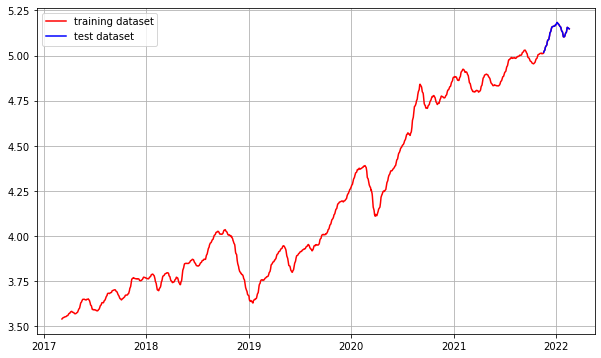

In [28]:
train_data, test_data = ts_log[:int(len(ts_log)*0.95)], ts_log[int(len(ts_log)*0.95):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

#### STEP 5 : 적정 ARIMA 모수 찾기

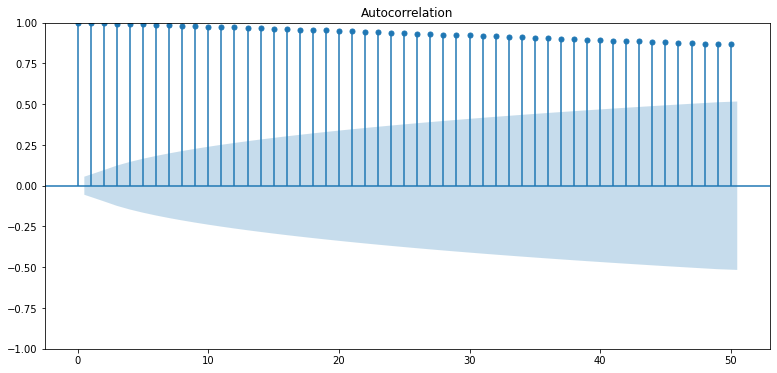

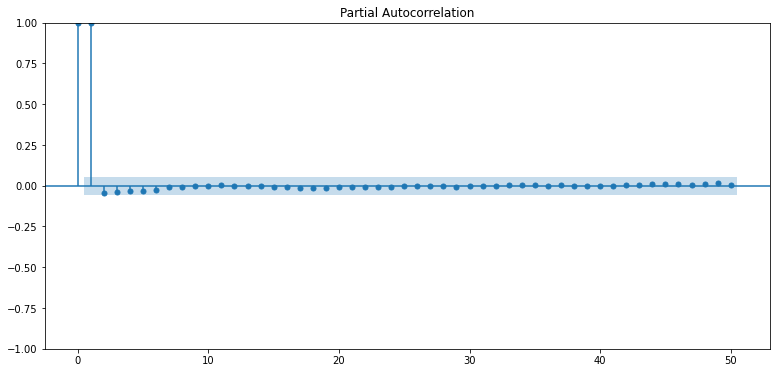

In [29]:
plot_acf(ts_log, lags=50)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log, lags=50)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

### pacf그래프로 p값을 찾아보면 3 정도로 보인다. acf 그래프로 q값을 찾아보면 0정도로 보인다.

Results of Dickey-Fuller Test:
Test Statistic                -6.017763e+00
p-value                        1.519223e-07
#Lags Used                     2.000000e+01
Number of Observations Used    1.228000e+03
Critical Value (1%)           -3.435686e+00
Critical Value (5%)           -2.863896e+00
Critical Value (10%)          -2.568025e+00
dtype: float64


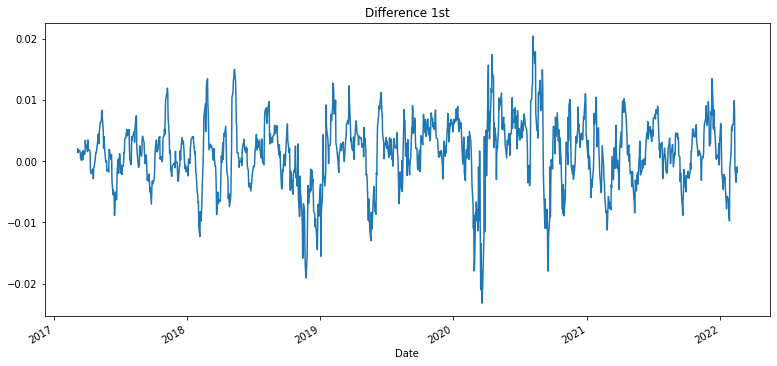

In [30]:
# 차분 안정성 확인 -> d 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

### 1차미분에 대한 p-value 1.519223e-07로 작은 값이며 d = 1값을 사용하였다.

#### STEP 6 : ARIMA 모델 훈련과 테스트  
ARIMA 모델 빌드와 훈련  
모델 테스트 및 플로팅  
최종 예측 모델 정확도 측정(MAPE)

In [31]:
from statsmodels.tsa.arima.model import ARIMA
# Build and Train  Model
model = ARIMA(train_data, order=(3, 1, 0)) # 모수는 이전 그래프를 참고 
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1187
Model:                 ARIMA(3, 1, 0)   Log Likelihood                5346.356
Date:                Fri, 18 Feb 2022   AIC                         -10684.712
Time:                        01:27:13   BIC                         -10664.399
Sample:                             0   HQIC                        -10677.056
                               - 1187                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7730      0.019     40.436      0.000       0.736       0.810
ar.L2          0.2022      0.023      8.749      0.000       0.157       0.247
ar.L3         -0.0868      0.019     -4.489      0.0

C:\Users\ami\anaconda3\envs\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ami\anaconda3\envs\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ami\anaconda3\envs\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


C:\Users\ami\anaconda3\envs\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


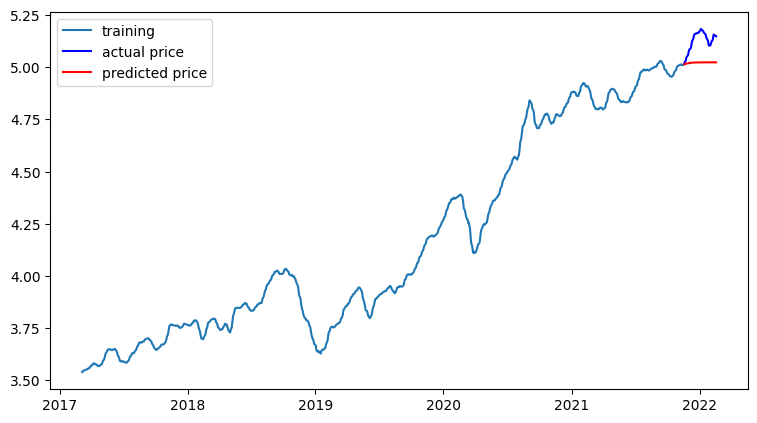

In [32]:
fc= fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r', label='predicted price')
plt.legend()
plt.show()

In [33]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  343.98697282424115
MAE:  17.23849274386915
RMSE:  18.546885798544217
MAPE: 10.04%


# Alphabet 주가예측

In [34]:
dataset_filepath = Path.joinpath(directory, 'GOOG.csv')
dataset_filepath = str(dataset_filepath)
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']
ts.head()

Date
2017-02-21    831.659973
2017-02-22    830.760010
2017-02-23    831.330017
2017-02-24    828.640015
2017-02-27    829.280029
Name: Close, dtype: float64

#### STEP 2 : 각종 전처리 수행  
결측치 처리  
로그 변환

In [35]:
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

In [36]:
ts=ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)

In [37]:
# 로그 변환
ts_log = np.log(ts)
# ts_log = ts

#### STEP 3 : 시계열 안정성 분석  
정성적 그래프 분석  
정량적 Augmented Dicky-Fuller Test  
시계열 분해(Time Series Decomposition)  
Residual 안정성 확인

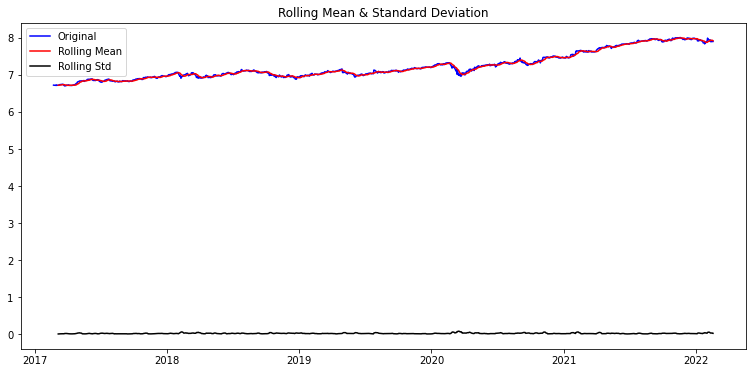

In [38]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=10)

In [39]:
rolmean = ts_log.rolling(window=10).mean() ##### rolmean을 사용해서 계산해 본다.
rolmean[rolmean.isna()] 

Date
2017-02-21   NaN
2017-02-22   NaN
2017-02-23   NaN
2017-02-24   NaN
2017-02-27   NaN
2017-02-28   NaN
2017-03-01   NaN
2017-03-02   NaN
2017-03-03   NaN
Name: Close, dtype: float64

In [40]:
rolmean_clean = rolmean.dropna()

In [41]:
ts_log = rolmean_clean

Results of Dickey-Fuller Test:
Test Statistic                   -0.359284
p-value                           0.916678
#Lags Used                       22.000000
Number of Observations Used    1227.000000
Critical Value (1%)              -3.435691
Critical Value (5%)              -2.863898
Critical Value (10%)             -2.568026
dtype: float64


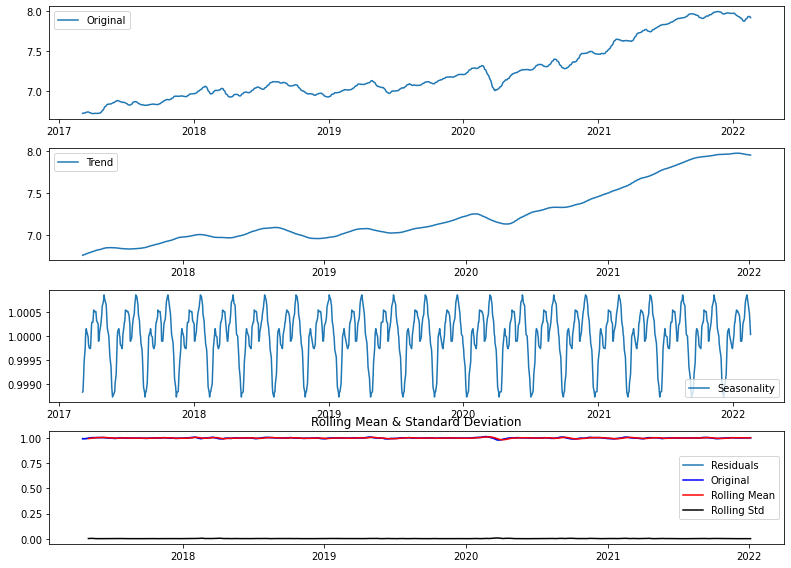

In [42]:
#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 60) 
trend         = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
seasonal      = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
residual      = decomposition.resid # 원본(로그변환한) - 추세 - 계절성

plt.rcParams["figure.figsize"] = (11,8)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

plt.rcParams["figure.figsize"] = (13,6)
plot_rolling_statistics(residual)

### 주식차트에서 흔히 사용되는 10일 평균선을 사용해서 나타내 보았지만 별다른 규칙성이라곤 찾아볼 수가 없다. p-value 또한 0.916678 으로 주기성이나 방향성이 가지고 있다고 보기는 어렵다.

#### STEP 4 : 학습, 테스트 데이터셋 생성

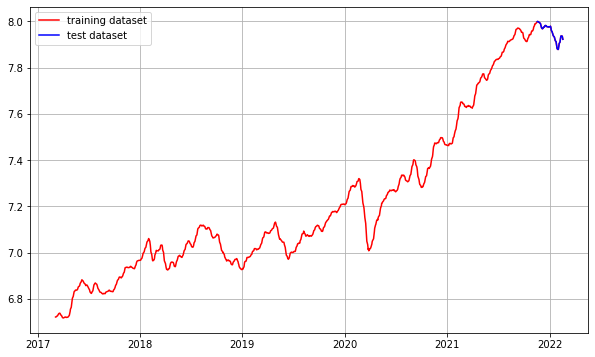

In [43]:
train_data, test_data = ts_log[:int(len(ts_log)*0.95)], ts_log[int(len(ts_log)*0.95):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

#### STEP 5 : 적정 ARIMA 모수 찾기

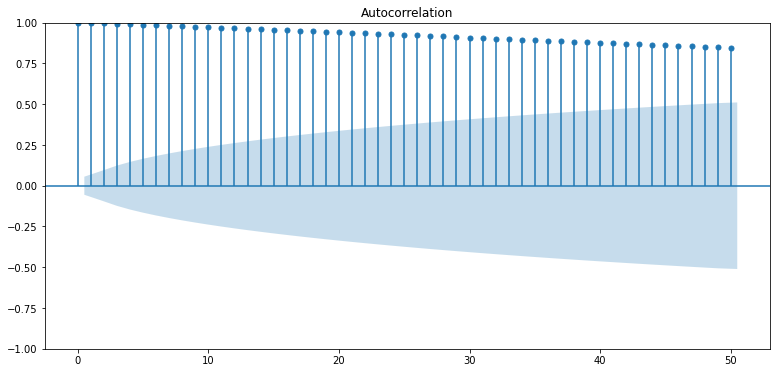

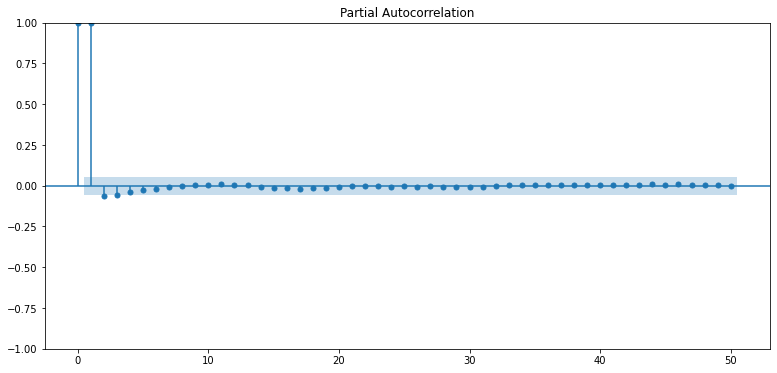

In [44]:
plot_acf(ts_log, lags=50)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log, lags=50)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

#### pacf그래프로 p값을 찾아보면 4 정도로 보인다. acf 그래프로 q값을 찾아보면 2정도로 보인다.

Results of Dickey-Fuller Test:
Test Statistic                -6.116317e+00
p-value                        9.076588e-08
#Lags Used                     2.100000e+01
Number of Observations Used    1.227000e+03
Critical Value (1%)           -3.435691e+00
Critical Value (5%)           -2.863898e+00
Critical Value (10%)          -2.568026e+00
dtype: float64


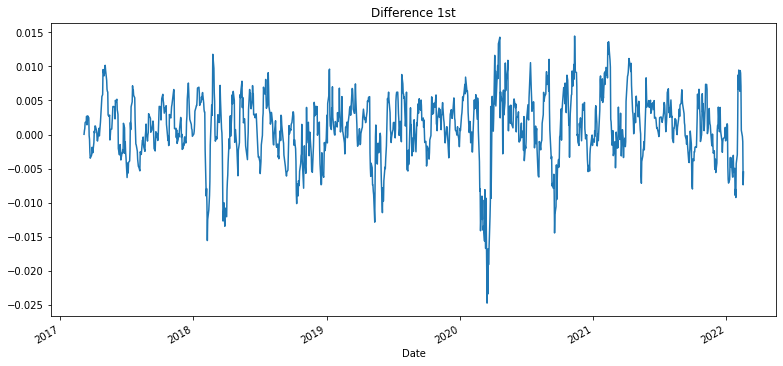

In [45]:
# 차분 안정성 확인 -> d 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

### 1차미분에 대한 p-value는 9.076588e-08로 작은 값이며 d = 1값을 사용하였다.

#### STEP 6 : ARIMA 모델 훈련과 테스트  
ARIMA 모델 빌드와 훈련  
모델 테스트 및 플로팅  
최종 예측 모델 정확도 측정(MAPE)

In [46]:
# Build and Train  Model
model = ARIMA(train_data, order=(4, 1, 2)) # 모수는 이전 그래프를 참고 
fitted_m = model.fit() 

print(fitted_m.summary())

C:\Users\ami\anaconda3\envs\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ami\anaconda3\envs\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ami\anaconda3\envs\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1187
Model:                 ARIMA(4, 1, 2)   Log Likelihood                5471.197
Date:                Fri, 18 Feb 2022   AIC                         -10928.393
Time:                        01:27:16   BIC                         -10892.845
Sample:                             0   HQIC                        -10914.995
                               - 1187                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1895      0.200      0.950      0.342      -0.202       0.581
ar.L2          0.1898      0.107      1.777      0.076      -0.020       0.399
ar.L3          0.2047      0.148      1.380      0.1

C:\Users\ami\anaconda3\envs\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


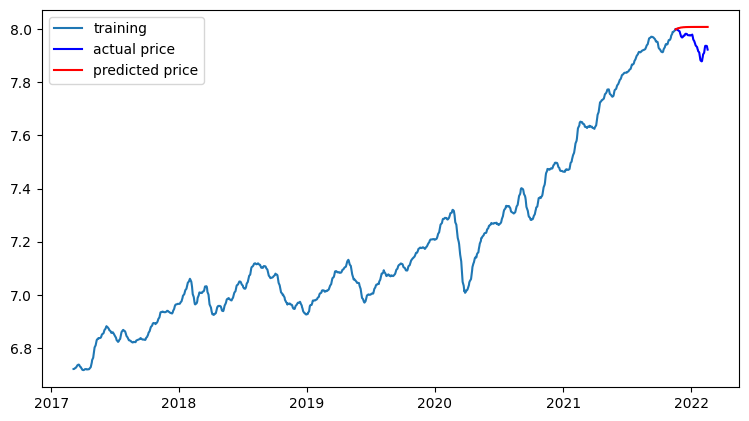

In [47]:

fc= fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r', label='predicted price')
plt.legend()
plt.show()

In [48]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  35009.54895261941
MAE:  157.05653912846634
RMSE:  187.1083882476128
MAPE: 5.66%


## 후기  

####  10일평균선으로 계산해보아도 p-value가 0.829~0.947로 평균값도 예측할 수 없는 상태이다. 

#### 원본 데이터로 계산해보았지만 직선형태가 나타나 계산의 의미가 없었다. 10일평균으로 계산하니 추세를 약간은 따라가는 그래프가 나왔다.

#### 주가에 주기성이나 계절성이 있었다면 주식시장이 있을 이유가 없을 것이다.

#### 주가의 예측은 시장경제에 영향을 미치는 요소들을 고려하여 계산되어야 할 것이다.
